<a href="https://colab.research.google.com/github/naratiz/Precoce-MS/blob/main/Otimiza%C3%A7%C3%A3o_Classifica%C3%A7%C3%A3o_RFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install plotly

     |████████████████████████████████| 15.2 MB 14.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#!pip install optuna
#!pip install plotly

import pandas as pd
import optuna
import time
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR, LinearSVR  
from sklearn.metrics import classification_report,confusion_matrix

<blockquote>
  <p>Treinamento dos dados com o algoritmo Random Forest Classifier da biblioteca Sikit-learn. Primeiramente utiliza-se os hiperparâmetros básicos para obter o modelo base, e após é aplicado o framework para otimização de hiperparâmetros, Optuna.</p>
</blockquote>

# Base de dados

In [2]:
df = pd.read_csv('../../dados/df_train_class.csv', sep=';')

In [4]:
print('A base de dados apresenta {} registros e {} características.'.format(df.shape[0], df.shape[1]))

A base de dados apresenta 672657 registros e 48 características.


## Separando os recursos do atributo alvo

In [3]:
SEED = 42
y = df['categoria']
X = df.drop(['categoria'],axis=1)

## StandardScaler

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA
Para reduzir a dimensão do conjunto de dados.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=SEED)

In [9]:
pca_test = PCA(n_components=40)
pca_test.fit(X_train)

PCA(n_components=40)

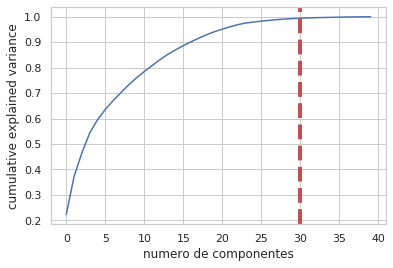

None

In [10]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('numero de componentes')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
display(plt.show())

In [11]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(40))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.223514,0.223514
1,0.373033,0.149519
2,0.465185,0.092153
3,0.543470,0.078284
4,0.594985,0.051515
5,0.635833,0.040848
6,0.670329,0.034496
7,0.701760,0.031431
8,0.732278,0.030518
9,0.759894,0.027616


Conforme o quadro acima, quando usamos o PCA para reduzir nossas 53 variáveis de previsão para 30 componentes,
ainda podemos explicar mais de 99% da variação.  
Usando essa lógica, usaremos o PCA para reduzir o número de componentes de 53 para 30 para X_train e X_test. 

In [5]:
pca = PCA(n_components=30)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)

## Baseline

In [13]:
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [ ]:
rfc_baseline = RandomForestClassifier(random_state=SEED)
scores = cross_val_score(rfc_baseline, X_scaled_pca, y, cv=skfolds)

In [17]:
print('Acurária %.3f +/- %.2f' % (scores.mean(), scores.std()))

Acurária 0.514 +/- 0.00


## Otimização dos hiperparâmetros

Utilização do framework [Optuna](https://https://optuna.readthedocs.io/en/stable/) para otimização de hiperparâmetros

In [6]:
# Manipulador de fluxo para mostrar as mensagens
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "rfc-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
# storage_name = "sqlite:///content/drive/MyDrive/Dissertação/dados/{}.db".format(study_name)

In [10]:
# função de otimização baseada em uma função objetivo
def tune(objective):
    study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, 
                                direction="maximize")
    study.optimize(objective, n_trials=5)
    
    params = study.best_params
    print(f"Trial: {study.best_trial.number}")
    print("\n")
    print(f"Melhor seleção de parâmetros : \n{params}")
    print("\n")
    print(f"Acurácia : {study.best_value:.3f}")
    
    return study, params

### Random Forest Classfier 


In [8]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [11]:
def randomforestclassfier_objective(trial: optuna.Trial): 
    rfc_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 400),
        "criterion" : trial.suggest_categorical("criterion", choices=["gini", "entropy"]),
        "max_depth":  trial.suggest_int("max_depth", 1, 100),
        "min_samples_split" : trial.suggest_int("min_samples_split", 1, 50),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", choices=["auto", "sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", choices=["True", "False"]),
        "random_state": SEED,
    }
    
    rfc = RandomForestClassifier(**rfc_params)
    scores = cross_val_score(rfc, X_scaled_pca, y, n_jobs=-1, cv=skfolds)
    accuracy = scores.mean()
    return accuracy

In [12]:
t0 = time.time()
study, rfc_params = tune(randomforestclassfier_objective)  
print("Pronto em:  %0.3f" %(time.time()-t0))

[I 2022-06-27 19:55:10,486] Using an existing study with name 'rfc-study' instead of creating a new one.


Using an existing study with name 'rfc-study' instead of creating a new one.


[I 2022-06-27 20:29:21,746] Trial 252 finished with value: 0.5149652803941913 and parameters: {'n_estimators': 363, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


Trial 252 finished with value: 0.5149652803941913 and parameters: {'n_estimators': 363, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


[I 2022-06-27 21:03:32,639] Trial 253 finished with value: 0.5147452570769815 and parameters: {'n_estimators': 365, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


Trial 253 finished with value: 0.5147452570769815 and parameters: {'n_estimators': 365, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 39, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


[I 2022-06-27 21:44:13,336] Trial 254 finished with value: 0.5144345486399042 and parameters: {'n_estimators': 356, 'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


Trial 254 finished with value: 0.5144345486399042 and parameters: {'n_estimators': 356, 'criterion': 'entropy', 'max_depth': 22, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


[I 2022-06-27 22:22:25,416] Trial 255 finished with value: 0.5142918318091606 and parameters: {'n_estimators': 340, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


Trial 255 finished with value: 0.5142918318091606 and parameters: {'n_estimators': 340, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 41, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


[I 2022-06-27 22:50:48,591] Trial 256 finished with value: 0.5147839105633256 and parameters: {'n_estimators': 364, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.


Trial 256 finished with value: 0.5147839105633256 and parameters: {'n_estimators': 364, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 42, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': 'True'}. Best is trial 245 with value: 0.5149801467346411.
Trial: 245


Melhor seleção de parâmetros : 
{'bootstrap': 'True', 'criterion': 'entropy', 'max_depth': 19, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 39, 'n_estimators': 366}


Acurácia : 0.515
Pronto em:  10538.211


Melhores valores para os hiperparâmentros:

In [13]:
rfc_params

{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 19,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 39,
 'n_estimators': 366}

<blockquote>
    <p>Acurácia baseline: 0.514 <br>
       Acurácia após otimização: 0.515
    </p>
</blockquote>

## Analisando a importância de cada variável

In [ ]:
# Determina quais hiperparâmetros tiveram o impacto mais significativo no desempenho geral do modelo.
optuna.visualization.plot_param_importances(study)

In [ ]:
model_rfc.fit(X_scaled_pca, y_train)

In [14]:
nomes_caracteristicas = []
for i in X.columns:
    nomes_caracteristicas.append(i)

In [ ]:
importancia = model_rfc.feature_importances_
# Importâncias de características são fornecidas pelo atributo ajustado feature_importances_ 
# e são calculadas como a média e o desvio padrão de acumulação da diminuição de impurezas dentro de cada árvore.
std = np.std([tree.feature_importances_ for tree in model_rfc.estimators_], axis=0)

In [ ]:
forest_importances = pd.Series(importancia, index=nomes_caracteristicas)
forest_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()